## Nonparametric Models: kNN, Decision Trees and Local Regression

Last revision: Thu 30 May 2024 15:10:00 AEST

This lab was tested with the following packages:

- `sklearn==1.4.2`
- `pandas==2.2.1`
- `numpy==1.26.4`
- `matplotlib==3.8.4`

## Introduction
In this lab we focus on Decision Trees in detail. We apply the existing `sklearn` implementation in both the classification and regression contexts, then discuss the nature of recursive partitioning in decision trees. In addition, a data analysis exercise is provided, to offer practice working with the `pandas` package. We finally attempt to implement a decision tree classifier.

## Decision Trees
The decision tree is a very important machine learning model, used as the building block for many more complex models such as the random forest and adaptive boosting algorithms. Decision trees can be thought of as a large set of `if-then-else` statements. They are also referred to as recursive partitioning algorithms, since they repeatedly partition the input space into smaller and smaller subsets or regions.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The following helper allows us to visualize classifiers, and you can use it as a black box for the remainder of the lab.

In [3]:
# Helper function for visualising classifiers and decision surfaces    
def visualize_classifier(model, X, y, ax=None, cmap='rainbow', title=None):
    
    # reference: Python Data Science Handbook by Jake VanderPlas
    ax = ax or plt.gca()
    
    # Plot the training points
    
    if np.any(y==-1):
        y[y==-1] = 0.   # fix to get scatter c=y arg working when we use -1,1 coding
    
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
                        clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # compute predictions on grid
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    if np.any(Z==-1):     # fix to get c=y working
        Z[Z==-1] = 0

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    if title:
        ax.set_title(title)

### Decision trees with `sklearn`

Recall that the `sklearn.datasets.make_blobs` function gives us a quick way to create toy data for classification. We will recreate the 3 class classification problem from Lab 02.

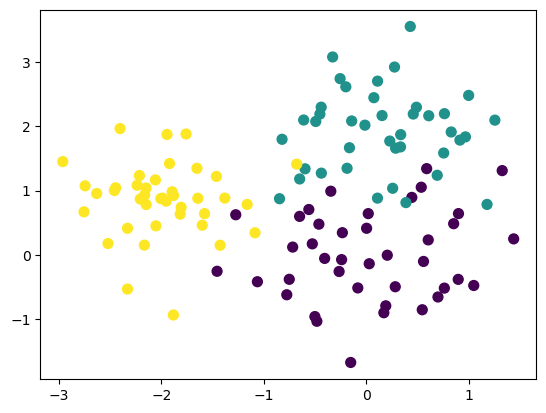

In [4]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=120,                           # total number of samples  
                  centers=[[0,0], [0,2], [-2,1]],          # cluster centers of the 3 classes
                  random_state=123,                        # reproducibility 
                  cluster_std=0.6)                         # how spread out are the samples from their center
                 
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)                   # scatter with color=label
plt.show()

For comparison, a k-nearest neighbours classifier and a decision tree classifier will be trained on this data. Typically, the following code is used to import the decision tree classifier.
```
from sklearn.tree import DecisionTreeClassifier
```
Again, the shaded regions correspond to how the classifier would classify a point that falls in that region. Note that for the kNN classifier, the regions are quite jagged, whereas the regions for the DT are always constructed by splitting using straight lines.

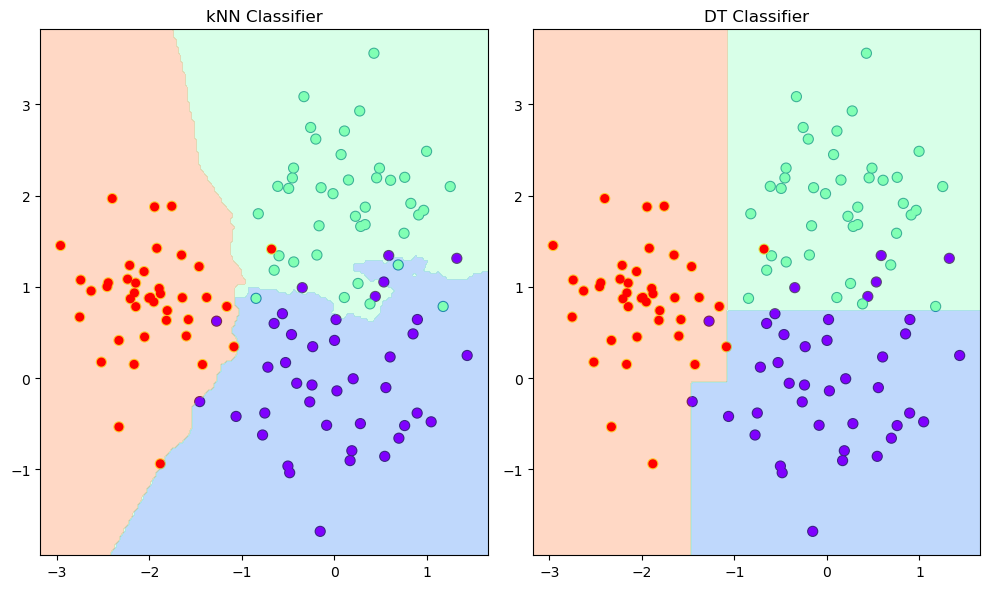

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# kNN with 5 neighbours and euclidean distance (p=2)
model0 = KNeighborsClassifier(n_neighbors=5, p=2)   

# DT with max depth of 3 and entropy criterion (this is information gain from lectures/tutorials)
model1 = DecisionTreeClassifier(max_depth=3, criterion='entropy', random_state=3)     

# fit both models
model0.fit(X,y)
model1.fit(X,y)


# visualize classifiers
fig, axes = plt.subplots(1,2, figsize=(10,6))

# scatter data
axes[0].scatter(X[:, 0], X[:, 1], c=y, s=50)
axes[1].scatter(X[:, 0], X[:, 1], c=y, s=50)

# classifier plot
visualize_classifier(model0, X, y, ax=axes[0], title="kNN Classifier")
visualize_classifier(model1, X, y, ax=axes[1], title="DT Classifier")

plt.tight_layout()
plt.show()


Another good way to visualize a tree is to look directly at the rules it uses to perform the splits at each depth. Recall that for a classification decision tree, we pass an input down the tree, and look at the majority class in the child node that it falls into to find its predicted class.

- The color of the label corresponds to the majority class at that particular node.
- How dark the node's colour is corresponds the purity of the node (relatively, how many samples actually belong to the majority class.)
- The plot also gives us the distribution of the three classes at each node (`value`), and tells us the number of samples that falls into a particular node.
- We also can see the entropy (`entropy`) for each node.

Because both features are numeric, it is possible they are used more than once for splitting. This is indeed observed below.

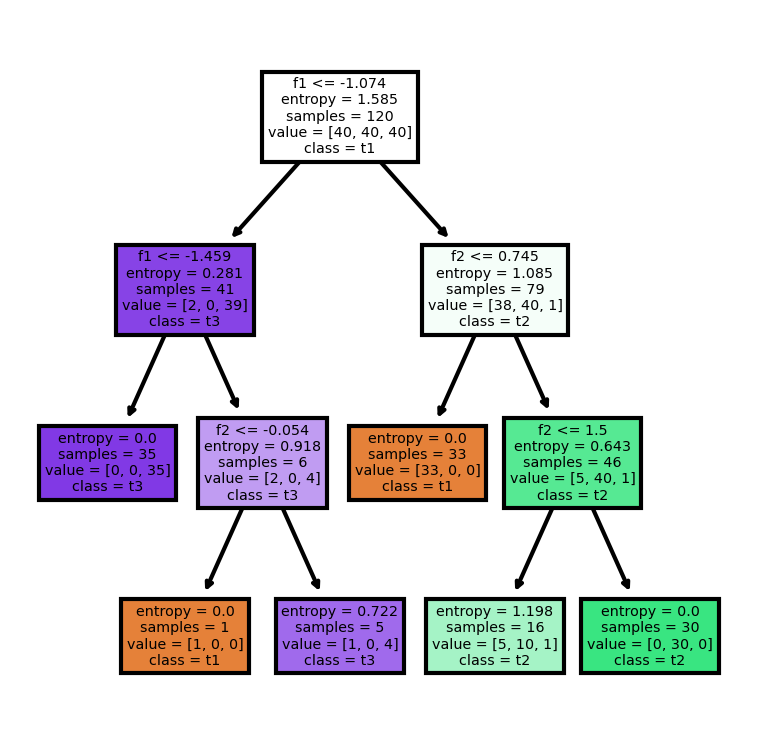

In [6]:
from sklearn import tree

fig, axes = plt.subplots(1, 1,figsize = (3,3), dpi=300)
tree.plot_tree(model1,                                      # fitted decision tree
               feature_names=['f1', 'f2'],                  # some names for the features
               class_names=['t1', 't2', 't3'],              # some names for the class labels
               filled=True)
plt.show()

Decision tree regression is fairly similar. The main changes are:
- During prediction, an average (or weighted average) of the points in the child node is used. This is similar to kNN regression.
- During training, a numeric loss such as MSE must be used. The optimal split is then chosen using a weighted average of the two MSEs in each split.

Fortunately, we need not concern ourselves with these details when using the `sklearn` implementation. The decision tree regressor is imported similarly:
```
from sklearn.tree import DecisionTreeRegressor
```

We will again simulate toy data from the model:

\begin{equation}
y=f(x) + \epsilon, \qquad f(x) = 0.3 \cos(x) + 0.4 \ln(10x), \quad \epsilon \sim N(0,\sigma^2), \quad \sigma=0.5.
\end{equation}

The `f_sampler` function created in Lab02 is included below, to generate the data.

In [7]:
def f_sampler(f, n=100, sigma=0.1, seed=None):
    if seed:
        np.random.seed(seed)
    
    # sample points from function f with Gaussian noise (0, sigma**2)
    xvals = np.random.uniform(low=1, high=10, size=n)
    yvals = f(xvals) + sigma * np.random.normal(0, 1,size=n)
    
    # build dataset D
    D = np.zeros(shape=(n, 2))
    D[:,0] = xvals; D[:,1] = yvals; 
    
    return D

The following code fits a regression tree with `max_depth` set to 3. A plot is produced showing the true model $f(x)$, the toy data, and the predictions from the fitted decision tree.

Note that in the regression setting, the jaggedness of the plot is very similar to that obtained from kNN regression.

In [8]:
from sklearn.tree import DecisionTreeRegressor

f = lambda x: 0.3 * np.cos(x) + 0.4 * np.log(10*x)
fsamples = f_sampler(f, 100, sigma=0.2, seed=200)

X = fsamples[:, 0].reshape(-1, 1) # enforce X to be 2-dimensional as per sklearn convention
y = fsamples[:, 1]

dt = DecisionTreeRegressor(max_depth=3).fit(X, y)

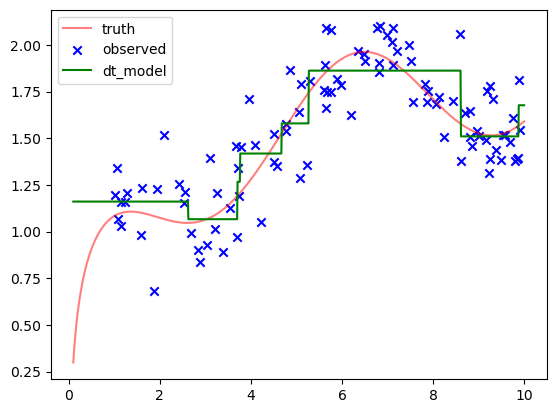

In [9]:
xx = np.linspace(0.1, 10, 1000)
plt.plot(xx, f(xx), alpha=0.5, color='red', label='truth')
plt.scatter(X, y, marker='x', color='blue', label='observed')
plt.plot(xx, dt.predict(xx.reshape(-1,1)), color='green', label='dt_model')
plt.legend()
plt.show()

Whilst we have focused on the `max_depth` hyperparameter, you are strongly encouraged to explore the results from modifying other hyperparameters of the decision tree.

### Recursive partitioning

<font color='purple'>
    
#### Exercise: 
Generate data using the following code:
    
```
X, y = make_blobs(n_samples=500,              
              centers=[[0,0], [0,2], [-2,1], [-2,2], [3,3], [1,-2]], 
              random_state=123, 
              cluster_std=0.6)  
```
Then fit a decision tree (using information gain for splits) with `max_depth` set to $1,2,\dots, 12$ and visualize the classifier (use a $3 \times 4$ grid). What do you observe? Why do you think decision trees are described as performing 'recursive partitioning'?

### Decision tree with real data

<font color='purple'>

#### Extended Data Exercise
In this exercise, we'll work with the `titanic.csv` dataset which you should have available in the same working directory where this notebook is located. If you get stuck at any point, the first thing to do will be to google your question - when it comes to data analysis in Python it is almost impossible to remember all the different commands, and https://stackoverflow.com/ is your best friend.
    
1. Using `pandas`, load in the dataset and call the dataframe `df`. Run `df.info()` to gain an understanding of the different features.

2. Remove the following columns `'PassengerId','Name', 'Ticket','Cabin', 'Embarked'` from the data, as we won't be using them for this exercise.
    
3. Use the `dropna()` method to remove any missing rows.
    
    
4. We would like to treat all attributes as numeric, so convert the `Sex` feature to numeric, and code males as 0 and females as 1. Hint: a good approach is to use the `pd.Series.map()` method on the `Sex` column, i.e., `df.Sex.map()`.
    
5. We will be interested in predicting `Survived` as a function of the remaining features. Create `X,y` `numpy` arrays to use for this problem. Be sure to also save a copy of the names of the columns. Hint: use `iloc` to index pandas dataframes, and use `to_numpy()` to convert pandas dataframes to numpy arrays.
    
6. Create train/test datasets using 70\% of your data for training.
    
7. Fit decision trees to your training dataset: do this for `max_depth`=1,...,20. For each depth, record the train and test classification error (1-accuracy). Create a plot of error against depth, and plot both the train and test errors. What do you notice?
    
8. Re-fit the model on the entire dataset with a depth 3 tree. Plot the decision tree and interpret the results.

Advanced exercise: complete Q2, Q3, Q4 all in the one go using *method chaining* in `pandas`. For Q4, one approach will be to use `pd.DataFrame.assign()`

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss

### Advanced material: Manual implementation of Decision Tree Classifier

Even the simplest implementations of the decision tree can be difficult, in comparison to other simple machine learning algorithms. This is mainly due to its recursive nature. Although one split can be implemented without much issue, the data structure needs to address that continuous splitting must occur, based on the hyperparameters provided.

The following exercise seeks to implement a decision tree in the same manner as a binary search tree, which you may have seen from COMP2521/COMP9024. The decision tree class will recursively store other decision trees in the `self.left` and `self.right` attributes, and proceed to fit until termination.

Note that the `sklearn` implementation of `DecisionTreeClassifier` and `DecisionTreeRegressor` opts out of this specific recursive approach due to computational inefficiency.

<font color='purple'>

#### Advanced exercise: Code up your own tree (helper functions)
In this section, we will code up some helper functions that will then be used to code up a decision tree from scratch for the titanic data considered above. Recall from lectures that  the decision tree algorithm is a simple recursion, you can use the following outline:
    
    
----------------- Decision Tree Algorithm -----------------
    
Let $S \subset \{ 1,2,\dots, n\}$ be a set of indices taken from the numbers $1,\dots, n$.
    
Set $S_0 \leftarrow \{ 1,2,\dots, n\}$
    
makeTree($S$):
 
1. If all labels in $S$ are the same, return a leaf node (terminal node) predicting that label. Mathematically: if ($y_i = C$ for all $i \in S$ then return leaf(C)) 
2. Otherwise,
    
    a. choose the best feature $(j)$ to split on and the best splitting value $(t)$
    
    b. split $S$ into a set of left and right datasets:
\begin{align*}
S_l = \{ i \in S: X_{ij} \le t \}\\
S_r = \{ i \in S: X_{ij} > t \}
\end{align*}
    
    c. return node(j, t, makeTree($S_l$), makeTree($S_r$)) 
    
    
----------------- Decision Tree Algorithm -----------------
    
    

Here we will choose the best feature by looking at the information gain, and to make things easier <font color=red>we will always split on the **mean** value of a particular feature</font>, even if the feature is categorical.
    
Fill in the blanks in the following code. Once you are done, you should have the following output:
    
```
X = df.drop(columns="Survived").values
y = df.Survived.values

for i, feature in enumerate(df.columns[1:]):
    print(feature)
    cutoff = df[feature].mean()
    print(information_gain(X, y, i, cutoff))  

Pclass
0.0841581440715109
Sex
0.21601606075154267
Age
2.6666107433293007e-08
SibSp
0.006904127996153864
Parch
0.019278172321014697
Fare
0.05371958996365228
```

In [ ]:
def divide_data(X, y, col_idx, cutoff):
    # divide x_data on feature: col_idx and cutoff value
    # col_idx is the column index referencing the variable to split on

    # create a numpy array of booleans for filter condition
    filter_right = ### TODO: condition
    filter_left = ### TODO: condition (elementwise logical negation)
    
    # split data into right and left datasets
    x_right = pd.DataFrame([], columns=x_data.columns)
    x_left = pd.DataFrame([], columns=x_data.columns)
    
    # use boolean condition to filter data
    X_right = X[] ### TODO: condition
    X_left =      ### TODO
    y_right =     ### TODO
    y_left =      ### TODO

    # return the divided datasets in the order 
    # X_left, X_right, y_left, y_right
    ### TODO

def entropy(y):
    # calculate the entropy H(p) = sum(-p_i*log_2(p_i))
    # here y will be the vector of targets (Survived, for titanic)
    # for simplicity, assume y only consists of non-negative int (0,1,2,...)
    
    # edge case where there is only one class
    if len(np.unique(y)) == 1:
        ### TODO

    # compute proportions
    # hint: np.bincount(y) computes counts
    ### TODO
    
    return ### TODO: return H(y)


def information_gain(X, y, col_idx, cutoff):
    # compute information gain when using col_idx to split on given cutoff
    # information gain: Entropy(current_node) - entropy gained by splitting on feature

    # case where there is only one class
    # use entropy of current node
    cur_ent = entropy(y)
    if cur_ent == 0.:
        # technically the information gain is zero
        # but we'll return negative infinity, just for safety
        return float('-Inf')
    
    # divide data on cutoff value
    (X_left, X_right, 
     y_left, y_right) = ### TODO
    
    
    # compute entropy of left and right node
    cur_ent = ### TODO
    left_ent = ### TODO
    right_ent = ### TODO
    
    # number of samples in left and right 
    left_n = ### TODO
    right_n = ### TODO
    total_n = ### TODO
    
    # calculate information gain
    IG = #TODO
    
    return IG

In [ ]:
X = df.drop(columns="Survived").values
y = df.Survived.values

for i, feature in enumerate(df.columns[1:]):
    print(feature)
    cutoff = df[feature].mean()
    print(information_gain(X, y, i, cutoff))

<font color='purple'>

#### Advanced exercise: Code up your own tree (ctd):
Now that you have code to compute the information gain of each feature, extend this to a full DecisionTree implementation using the code below as a template, and the comments as hints. At the end, you should get a test accuracy of about 84\% using the following code:
```    
X = df.drop(columns="Survived").values
y = df.Survived.values

split = int(0.8 * df.shape[0])
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

dt = DecisionTree(verbose=True)
dt.train(X_train, y_train)

y_pred = dt.predict(X_test)
print('accuracy =', np.sum(y_pred == y_test)/len(y_test))
```

In [ ]:
class DecisionTree:
    def __init__(self, cur_depth=0, max_depth=5, verbose=False):
        self.left = None
        self.right = None
        self.feature = None
        self.cutoff = None
        self.max_depth = max_depth
        self.cur_depth = cur_depth
        self.target = None
        self.verbose = verbose    # tree depth during training if verbose==True

    def _divide_data(self, X, y, col_idx, cutoff):
        ### TODO: copy paste your code from the previous part

    def _entropy(self, y):
        ### TODO: copy paste your code from the previous part

    def _information_gain(self, X, y, col_idx, cutoff):
        ### TODO: copy paste your code from the previous part
        # remember to change divide_data() to self._divide_data()
        # and likewise for entropy

    
    def train(self, X, y):
        # X and y should be 2D and 1D numpy arrays of inputs respectively
        
        if self.verbose:
            print(self.cur_depth, '-'*10)

        # if current node is pure (all class labels are the same)
        # or if max depth reached, then return early:
        if len(np.unique(y)) == 1 or self.cur_depth>=self.max_depth:
            ### TODO: assign "self.target" to the prediction
            # hint: use np.bincount(y) to first get counts for the target variable y
            self.target = ### TODO
            return
        
        
        # At current node, find best feature to split on (feature with largest IG)
        # optional challenge: rewrite this with list comprehension, deleting the cutoff variable
        IGs = []
        for fx in df.columns[1:]:
            cutoff = ### TODO
            IGs.append(### TODO)
        
        # store the best feature and corresponding cutoff (using max information gain)
        self.feature = ### TODO
        self.cutoff = ### TODO
        
        # divide the dataset
        data_left, data_right = ### TODO
        
        # reset index of left and right datasets (pandas technicality, otherwise row indexing stay the same)
        data_left = data_left.reset_index(drop=True)
        data_right = data_right.reset_index(drop=True)
        
        # grow the tree by creating new DecisionTree objects
        # and assigning them to self.left and self.right
        
        # branch to right
        self.right = DecisionTree(self.cur_depth+1,
                                  self.max_depth,
                                  verbose=self.verbose)
        self.right.train(X_right, y_right)
        
        # branch to left
        self.left = ### TODO
        #TODO (train left)
        
        self.target = ### TODO
        

     def _check_tree_valid(self):
        # the tree is implemented so that x.left or x.right should either exist
        # or they should both be none.
        if self.left is not None and self.right is not None:
            return
        if self.left is None and self.right is None:
            return

        raise AttributeError("Decision tree class has one and only one "
                             "of self.left and self.right specified?")

    
    def predict(self, x):
        # predict for one single sample x
        self._check_tree_valid()

        # if root node, return the predicted value
        if self.right is None:
            return self.target
            
        # else pass the value down the tree
        
        if x[self.feature] > self.cutoff:
            # go right
            return ### TODO
        else:
            # go left
            return ### TODO

In [ ]:
X = df.drop(columns="Survived").values
y = df.Survived.values

split = int(0.8 * df.shape[0])
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

dt = DecisionTree(verbose=True)
dt.train(X_train, y_train)

In [ ]:
y_pred = dt.predict(X_test)
print('accuracy =', np.sum(y_pred == y_test)/len(y_test))

Note that you can access the tree structure by accessing the object attributes. Obviously this is not nearly as nice as the tree plotter we saw before!

In [ ]:
# should output Sex, Pclass, SibSp, Age
print(f'root node: feature used for split = {fnames[dt.col_idx]}')
print(f'right child of root node: feature used for split = {fnames[dt.right.col_idx]}')
print(f'rightmost grand child of root node: feature used for split = {fnames[dt.right.right.col_idx]}')
print(f'left child of rightmost grandchild of root node: feature used for split = {fnames[dt.right.right.left.col_idx]}')

For concreteness, let's compare this to the sklearn decision tree performance:

In [ ]:
# note: criterion = gini gives a better accuracy here!
DT = DecisionTreeClassifier(max_depth=5, criterion="entropy")
DT.fit(X[:split], y[:split])
print('sklearn DT test accuracy:', DT.score(X[split:], y[split:]))

We can also use this decision tree for the data generated with `sklearn.make_blobs` earlier.

In [ ]:
X, y = make_blobs(n_samples=120,                           # total number of samples  
                  centers=[[0,0], [0,2], [-2,1]],          # cluster centers of the 3 classes
                  random_state=123,                        # reproducibility 
                  cluster_std=0.6)                         # how spread out are the samples from their center

split = 90
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

# include verbose=True if desired
dt = DecisionTree()
dt.train(X_train, y_train)

In [ ]:
y_pred = dt.predict(X_test)
print('accuracy =', np.sum(y_pred == y_test)/len(y_test))

In [ ]:
DT = DecisionTreeClassifier(max_depth=5, criterion="entropy")
DT.fit(X[:split], y[:split])
print('sklearn DT test accuracy:', DT.score(X[split:], y[split:]))